<a href="https://colab.research.google.com/github/Aoi2002/Quants-project/blob/main/Quantitative_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  10 of 10 completed
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestR

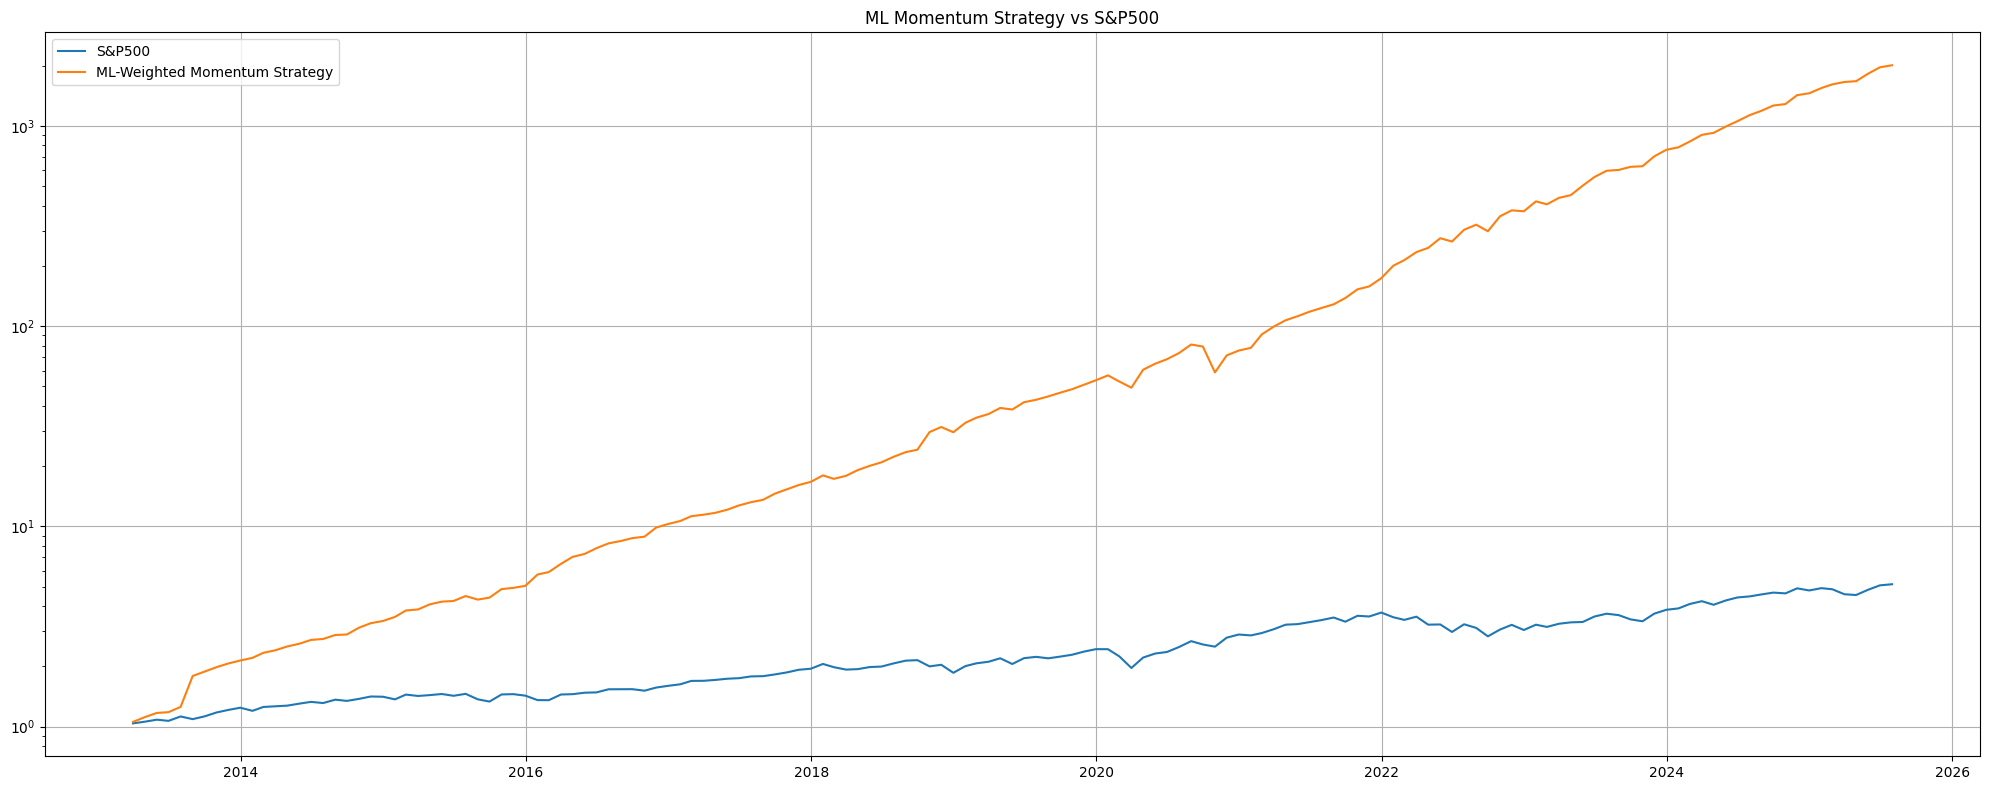

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 銘柄リスト
tickers = tickers = ["XLK", "XLY", "XLP", "XLU", "XLI", "XLE", "XLF", "XLV", "VNQ", "DBC"]

# データ取得と前処理
prices = yf.download(tickers, start="2005-01-01", auto_adjust=True)["Close"]
prices = prices.resample("ME").last()
returns = prices.pct_change().dropna()

# 特徴量作成関数
def create_features(prices):
    features = pd.DataFrame(index=prices.index)
    for ticker in prices.columns:
        features[f"{ticker}_mom"] = prices[ticker].pct_change(12) - prices[ticker].pct_change(1)
        features[f"{ticker}_vol"] = prices[ticker].pct_change().rolling(12).std()
        features[f"{ticker}_resid"] = prices[ticker] - prices[ticker].rolling(12).mean()
    return features.dropna()

features = create_features(prices)
target = returns.shift(-1)  # 翌月リターンをターゲット

# 機械学習スコア加重モメンタム戦略
strategy_returns = []
dates = features.index[72:-1]  # 初期学習72ヶ月分使う
for date in dates:
    X_train = features.loc[:date].iloc[-72:]
    y_train = target.loc[:date].iloc[-72:]

    X_pred = features.loc[date].values.reshape(1, -1)
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_pred)[0], index=returns.columns)

    # スコア上位3銘柄で重み計算
    top_assets = y_pred.nlargest(3)
    weights = top_assets / top_assets.sum()
    next_date = date + pd.offsets.MonthEnd(1)
    realized_ret = (returns.loc[next_date, weights.index] * weights).sum()
    strategy_returns.append(realized_ret)

# 時系列構築
strategy_returns = pd.Series(strategy_returns, index=dates + pd.offsets.MonthEnd(1))
strategy_cum = (1 + strategy_returns).cumprod()

# ベンチマーク（S&P500）
# ベンチマーク（S&P500）
spy = yf.download("SPY", start="2005-01-01", auto_adjust=True)["Close"]
spy = spy.resample("ME").last()
spy_returns = spy.pct_change().dropna()
spy_returns = spy_returns.reindex(strategy_returns.index)  # 修正済み
spy_cum = (1 + spy_returns.dropna()).cumprod()

# グラフ描画
plt.figure(figsize=(20, 8))
plt.plot(spy_cum, label="S&P500")
plt.plot(strategy_cum, label="ML-Weighted Momentum Strategy")
plt.yscale("log")
plt.title("ML Momentum Strategy vs S&P500")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
def evaluate_performance(strategy_returns, benchmark_returns, risk_free_rate=0.0):
    summary = pd.DataFrame(index=["Annual Return", "Cumulative Return", "Sharpe Ratio"])

    def annual_ret(r):
        return (1 + r.mean())**12 - 1

    def cum_ret(r):
        return (1 + r).prod() - 1

    def sharpe(r, rf):
        excess = r - rf / 12
        return (excess.mean() / excess.std()) * np.sqrt(12)

    summary["Strategy"] = [
        annual_ret(strategy_returns),
        cum_ret(strategy_returns),
        sharpe(strategy_returns, risk_free_rate)
    ]
    summary["S&P500"] = [
        annual_ret(benchmark_returns),
        cum_ret(benchmark_returns),
        sharpe(benchmark_returns, risk_free_rate)
    ]

    print("=== Performance Comparison ===")
    print(summary.round(4))
    return summary


In [12]:
# === ① Performance Comparison ===
print("【① 年率・累積リターン・シャープレシオ比較】")
performance_table = evaluate_performance(strategy_returns, spy_returns)
print(performance_table)

【① 年率・累積リターン・シャープレシオ比較】
=== Performance Comparison ===
                    Strategy                                 S&P500
Annual Return         0.8841  Ticker
SPY    0.152675
dtype: float64
Cumulative Return  2007.8051  Ticker
SPY    4.140862
dtype: float64
Sharpe Ratio          2.9905  Ticker
SPY    0.991605
dtype: float64
                      Strategy                                 S&P500
Annual Return         0.884058  Ticker
SPY    0.152675
dtype: float64
Cumulative Return  2007.805067  Ticker
SPY    4.140862
dtype: float64
Sharpe Ratio          2.990520  Ticker
SPY    0.991605
dtype: float64


In [24]:
# ドローダン計算
def calculate_drawdown(cumulative_returns):
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    max_drawdown = drawdown.min()

    # 最大ドローダウン期間
    dd_flag = (drawdown < 0).astype(int)
    dd_periods = dd_flag.groupby((dd_flag == 0).cumsum()).sum()
    max_dd_duration = dd_periods.max()

    return drawdown, max_drawdown, max_dd_duration

# ドローダウン計算（戦略）
strategy_dd, strategy_max_dd, strategy_max_dd_duration = calculate_drawdown(strategy_cum)

# 結果表示
print(f"[ML戦略] 最大ドローダウン: {strategy_max_dd:.2%}")
print(f"[ML戦略] 最大ドローダウン期間: {strategy_max_dd_duration}ヶ月")

# S&P500にも同様に適用
spy_dd, spy_max_dd, spy_max_dd_duration = calculate_drawdown(spy_cum)
print(f"[S&P500] 最大ドローダウン: {spy_max_dd:.2%}")
print(f"[S&P500] 最大ドローダウン期間: {spy_max_dd_duration}ヶ月")



[ML戦略] 最大ドローダウン: -27.42%
[ML戦略] 最大ドローダウン期間: 5ヶ月
[S&P500] 最大ドローダウン: -23.93%
[S&P500] 最大ドローダウン期間: 23ヶ月


In [25]:
def create_momentum_only_features(prices):
    features = pd.DataFrame(index=prices.index)
    for ticker in prices.columns:
        features[f"{ticker}_mom"] = prices[ticker].pct_change(12) - prices[ticker].pct_change(1)
    return features.dropna()

In [27]:
def run_momentum_only_backtest_rf(prices, returns):
    features = create_momentum_only_features(prices)
    target = returns.shift(-1)  # 翌月のリターン

    strategy_returns = []
    dates = features.index[72:-1]  # 最初の72ヶ月は学習用
    for date in dates:
        X_train = features.loc[:date].iloc[-72:]
        y_train = target.loc[:date].iloc[-72:]
        X_pred = features.loc[date].values.reshape(1, -1)

        model = RandomForestRegressor(n_estimators=100, random_state=0)
        model.fit(X_train, y_train)
        y_pred = pd.Series(model.predict(X_pred)[0], index=returns.columns)

        top_assets = y_pred.nlargest(3)
        weights = top_assets / top_assets.sum()
        next_date = date + pd.offsets.MonthEnd(1)
        realized_ret = (returns.loc[next_date, weights.index] * weights).sum()
        strategy_returns.append(realized_ret)

    strategy_returns = pd.Series(strategy_returns, index=dates + pd.offsets.MonthEnd(1))
    return strategy_returns

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

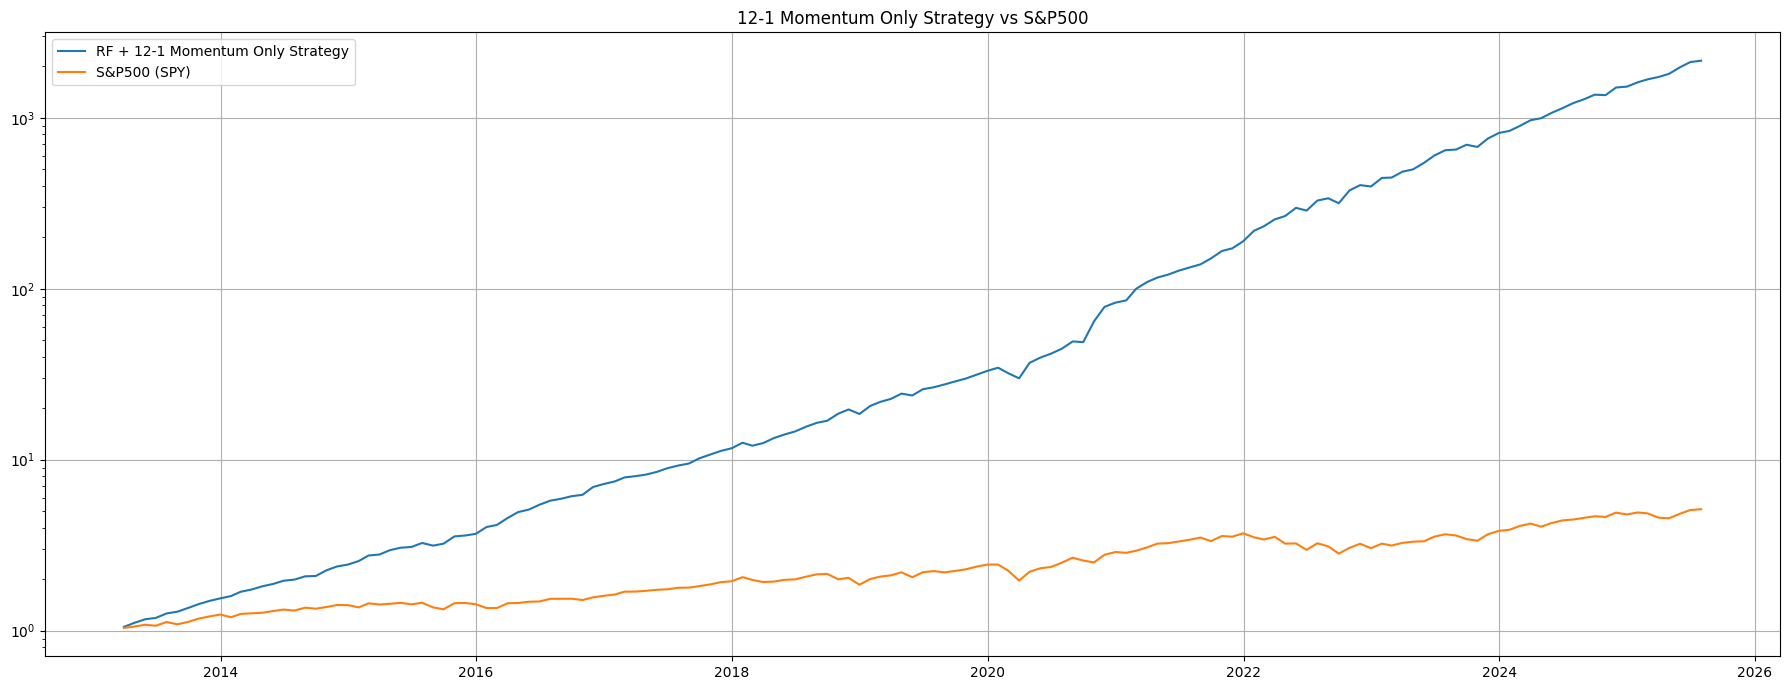

In [28]:
# モメンタム単体戦略の実行
momentum_only_returns = run_momentum_only_backtest_rf(prices, returns)
momentum_only_cum = (1 + momentum_only_returns).cumprod()

# S&P500（ベンチマーク）の累積リターン
spy = yf.download("SPY", start="2005-01-01", auto_adjust=True)["Close"]
spy = spy.resample("ME").last()
spy_returns = spy.pct_change().dropna()
spy_returns = spy_returns.reindex(momentum_only_returns.index)  # 同期間に揃える
spy_cum = (1 + spy_returns).cumprod()

# プロット
plt.figure(figsize=(18, 7))
plt.plot(momentum_only_cum, label="RF + 12-1 Momentum Only Strategy")
plt.plot(spy_cum, label="S&P500 (SPY)")
plt.yscale("log")
plt.title("12-1 Momentum Only Strategy vs S&P500")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()